# Time series Weather Forecasting

In [1]:
# time series library import
import os 
import datetime 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

2025-09-30 17:50:01.499405: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 17:50:01.501116: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-30 17:50:01.508635: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-30 17:50:01.528542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759236601.562063  332922 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759236601.57

In [2]:
# default set matplotlib figure size and no grid
mpl.rcParams['figure.figsize'] = (15, 6)
mpl.rcParams['axes.grid'] = False

## impot the weather dataset

In [3]:
# import weather dataset
zip_path = tf.keras.utils.get_file(
    origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname = 'jena_climate_2009_2016.csv.zip',
    extract = True)

print(zip_path)

data_dir, _ = os.path.splitext(zip_path)
print("Extracted folder:", data_dir)

# Full path to CSV file inside the extracted folder
csv_file = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
print(csv_file)

/home/tk-lpt-648/.keras/datasets/jena_climate_2009_2016_extracted
Extracted folder: /home/tk-lpt-648/.keras/datasets/jena_climate_2009_2016_extracted
/home/tk-lpt-648/.keras/datasets/jena_climate_2009_2016_extracted/jena_climate_2009_2016.csv


In [4]:
# read the data in pandas dataframe
df = pd.read_csv(csv_file)
df.head()
# # write the csv file
# df.to_csv('jena_climate_2009_2016.csv')

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1  01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2  01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3  01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4  01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   
1          3.23          3.02          0.21       1.89             3.03   
2          3.21          3.01          0.20       1.88             3.02   
3          3.26          3.07          0.19       1.92             3.08   
4          3.27          3.08          0.19       1.92             3.09   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3  
1       1309.80      0.72           1.50     136.1  
2       1310.24      0.19           0.63     171.6  
3       1309.19      0.34           0.50     198.0  
4       1309.00      0.32           0.63     214.3

In [5]:
df.shape


(420551, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


In [7]:
df.describe().transpose() # converted columns to rows and rows to columns

count         mean        std      min      25%      50%  \
p (mbar)         420551.0   989.212776   8.358481   913.60   984.20   989.58   
T (degC)         420551.0     9.450147   8.423365   -23.01     3.36     9.42   
Tpot (K)         420551.0   283.492743   8.504471   250.60   277.43   283.47   
Tdew (degC)      420551.0     4.955854   6.730674   -25.01     0.24     5.22   
rh (%)           420551.0    76.008259  16.476175    12.95    65.21    79.30   
VPmax (mbar)     420551.0    13.576251   7.739020     0.95     7.78    11.82   
VPact (mbar)     420551.0     9.533756   4.184164     0.79     6.21     8.86   
VPdef (mbar)     420551.0     4.042412   4.896851     0.00     0.87     2.19   
sh (g/kg)        420551.0     6.022408   2.656139     0.50     3.92     5.59   
H2OC (mmol/mol)  420551.0     9.640223   4.235395     0.80     6.29     8.96   
rho (g/m**3)     420551.0  1216.062748  39.975208  1059.45  1187.49  1213.79   
wv (m/s)         420551.0     1.702224  65.446714 -9999.00     0.99     1.76   
max. wv (m/s)    420551.0     3.056555  69.016932 -9999.00     1.76     2.96   
wd (deg)         420551.0   174.743738  86.681693     0.00   124.90   198.10   

                     75%      max  
p (mbar)          994.72  1015.35  
T (degC)           15.47    37.28  
Tpot (K)          289.53   311.34  
Tdew (degC)        10.07    23.11  
rh (%)             89.40   100.00  
VPmax (mbar)       17.60    63.77  
VPact (mbar)       12.35    28.32  
VPdef (mbar)        5.30    46.01  
sh (g/kg)           7.80    18.13  
H2OC (mmol/mol)    12.49    28.82  
rho (g/m**3)     1242.77  1393.54  
wv (m/s)            2.86    28.49  
max. wv (m/s)       4.74    23.50  
wd (deg)          234.10   360.00

In [8]:
df.head(20)

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0   01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
1   01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2   01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
3   01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
4   01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   
5   01.01.2009 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
6   01.01.2009 01:10:00    996.50     -7.62    265.81        -8.30    94.8   
7   01.01.2009 01:20:00    996.50     -7.62    265.81        -8.36    94.4   
8   01.01.2009 01:30:00    996.50     -7.91    265.52        -8.73    93.8   
9   01.01.2009 01:40:00    996.53     -8.43    264.99        -9.34    93.1   
10  01.01.2009 01:50:00    996.62     -8.76    264.66        -9.66    93.1   
11  01.01.2009 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
12  01.01.2009 02:10:00    996.63     -8.85    264.57        -9.70    93.5   
13  01.01.2009 02:20:00    996.74     -8.83    264.58        -9.68    93.5   
14  01.01.2009 02:30:00    996.81     -8.66    264.74        -9.46    93.9   
15  01.01.2009 02:40:00    996.81     -8.66    264.74        -9.50    93.6   
16  01.01.2009 02:50:00    996.86     -8.70    264.70        -9.55    93.5   
17  01.01.2009 03:00:00    996.84     -8.81    264.59        -9.66    93.5   
18  01.01.2009 03:10:00    996.87     -8.84    264.56        -9.69    93.5   
19  01.01.2009 03:20:00    996.97     -8.94    264.45        -9.82    93.3   

    VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0           3.33          3.11          0.22       1.94             3.12   
1           3.23          3.02          0.21       1.89             3.03   
2           3.21          3.01          0.20       1.88             3.02   
3           3.26          3.07          0.19       1.92             3.08   
4           3.27          3.08          0.19       1.92             3.09   
5           3.33          3.14          0.19       1.96             3.15   
6           3.44          3.26          0.18       2.04             3.27   
7           3.44          3.25          0.19       2.03             3.26   
8           3.36          3.15          0.21       1.97             3.16   
9           3.23          3.00          0.22       1.88             3.02   
10          3.14          2.93          0.22       1.83             2.94   
11          3.12          2.90          0.21       1.81             2.91   
12          3.12          2.92          0.20       1.82             2.93   
13          3.13          2.92          0.20       1.83             2.93   
14          3.17          2.98          0.19       1.86             2.99   
15          3.17          2.97          0.20       1.85             2.98   
16          3.16          2.95          0.21       1.85             2.96   
17          3.13          2.93          0.20       1.83             2.94   
18          3.13          2.92          0.20       1.83             2.93   
19          3.10          2.89          0.21       1.81             2.90   

    rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0        1307.75      1.03           1.75     152.3  
1        1309.80      0.72           1.50     136.1  
2        1310.24      0.19           0.63     171.6  
3        1309.19      0.34           0.50     198.0  
4        1309.00      0.32           0.63     214.3  
5        1307.86      0.21           0.63     192.7  
6        1305.68      0.18           0.63     166.5  
7        1305.69      0.19           0.50     118.6  
8        1307.17      0.28           0.75     188.5  
9        1309.85      0.59           0.88     185.0  
10       1311.64      0.45           0.88     183.2  
11       1312.25      0.25           0.63     190.3  
12       1312.11      0.16           0.50     158.3  
13       1312.15      

In [9]:
# reduce the data and take data after every 2 hours instead of every 10 minutes

# select every 12th row
# df_12 = df.iloc[11::12, :] # data of every 2 hours interval - df.iloc[11::12, :] means; [start:stop:step]
df_12 = df[11::12] # same as above
df_12.head(20)

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
11   01.01.2009 02:00:00    996.62     -8.88    264.54        -9.77    93.2   
23   01.01.2009 04:00:00    996.99     -9.05    264.34       -10.02    92.6   
35   01.01.2009 06:00:00    997.71     -9.67    263.66       -10.62    92.7   
47   01.01.2009 08:00:00    999.17     -8.10    265.12        -9.05    92.8   
59   01.01.2009 10:00:00   1000.27     -7.04    266.10        -8.17    91.6   
71   01.01.2009 12:00:00   1000.30     -6.87    266.27        -8.28    89.6   
83   01.01.2009 14:00:00    999.81     -5.94    267.24        -7.43    89.1   
95   01.01.2009 16:00:00    999.94     -5.40    267.76        -6.86    89.4   
107  01.01.2009 18:00:00   1000.16     -5.25    267.90        -6.75    89.1   
119  01.01.2009 20:00:00   1000.22     -4.90    268.24        -6.38    89.3   
131  01.01.2009 22:00:00   1000.00     -4.50    268.66        -5.82    90.4   
143  02.01.2009 00:00:00    999.59     -4.54    268.65        -5.46    93.2   
155  02.01.2009 02:00:00    998.93     -4.29    268.95        -5.04    94.5   
167  02.01.2009 04:00:00    998.32     -4.58    268.71        -5.22    95.2   
179  02.01.2009 06:00:00    998.00     -4.43    268.88        -4.94    96.2   
191  02.01.2009 08:00:00    998.18     -4.33    268.97        -5.04    94.8   
203  02.01.2009 10:00:00    998.65     -3.93    269.34        -4.99    92.3   
215  02.01.2009 12:00:00    998.91     -3.12    270.13        -4.50    90.1   
227  02.01.2009 14:00:00    998.73     -2.56    270.70        -4.29    87.8   
239  02.01.2009 16:00:00    999.59     -2.76    270.43        -4.22    89.6   

     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
11           3.12          2.90          0.21       1.81             2.91   
23           3.07          2.85          0.23       1.78             2.85   
35           2.93          2.71          0.21       1.69             2.72   
47           3.31          3.07          0.24       1.92             3.08   
59           3.60          3.30          0.30       2.05             3.29   
71           3.64          3.27          0.38       2.03             3.26   
83           3.92          3.49          0.43       2.17             3.49   
95           4.08          3.65          0.43       2.27             3.65   
107          4.13          3.68          0.45       2.29             3.68   
119          4.24          3.79          0.45       2.36             3.78   
131          4.37          3.95          0.42       2.46             3.95   
143          4.36          4.06          0.30       2.53             4.06   
155          4.44          4.20          0.24       2.62             4.20   
167          4.34          4.14          0.21       2.58             4.14   
179          4.39          4.23          0.17       2.64             4.23   
191          4.43          4.20          0.23       2.62             4.20   
203          4.56          4.21          0.35       2.63             4.22   
215          4.85          4.37          0.48       2.73             4.38   
227          5.06          4.44          0.62       2.77             4.45   
239          4.98          4.46          0.52       2.78             4.46   

     rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
11        1312.25      0.25           0.63    190.30  
23        1313.61      0.10           0.38    240.00  
35        1317.71      0.05           0.50    146.00  
47        1311.65      0.72           1.25    213.90  
59        1307.76      1.45           3.00    292.60  
71        1306.98      1.84           2.63    184.40  
83        1301.67      1.25           2.00    144.00  
95        1299.17      1.40           2.13    145.50  
107       1298.68      0.55           1.00    183.70  
119       1297.05      0.68           1.13    195.20  
131       1294.72      0.33           0.63    175.70  
143       1294.33      0.41           0.88    155.00  
155       1292.22     

In [10]:
print(df_12.shape)
print(df.shape)

(35045, 15)
(420551, 15)


In [11]:
# extract Date Time column from df_12 and remove this column from df_12
date_time = pd.to_datetime(df_12['Date Time'], format='%d.%m.%Y %H:%M:%S')
df_12 = df_12.drop(columns=['Date Time']) # remove Date Time column
print(date_time)
print(df_12)

11       2009-01-01 02:00:00
23       2009-01-01 04:00:00
35       2009-01-01 06:00:00
47       2009-01-01 08:00:00
59       2009-01-01 10:00:00
                 ...        
420491   2016-12-31 14:10:00
420503   2016-12-31 16:10:00
420515   2016-12-31 18:10:00
420527   2016-12-31 20:10:00
420539   2016-12-31 22:10:00
Name: Date Time, Length: 35045, dtype: datetime64[ns]
        p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
11        996.62     -8.88    264.54        -9.77   93.20          3.12   
23        996.99     -9.05    264.34       -10.02   92.60          3.07   
35        997.71     -9.67    263.66       -10.62   92.70          2.93   
47        999.17     -8.10    265.12        -9.05   92.80          3.31   
59       1000.27     -7.04    266.10        -8.17   91.60          3.60   
...          ...       ...       ...          ...     ...           ...   
420491   1003.25      4.15    277.05        -3.76   56.20          8.22   
420503   1002.54      2.44 

In [12]:
df_12.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>],
      dtype=object)

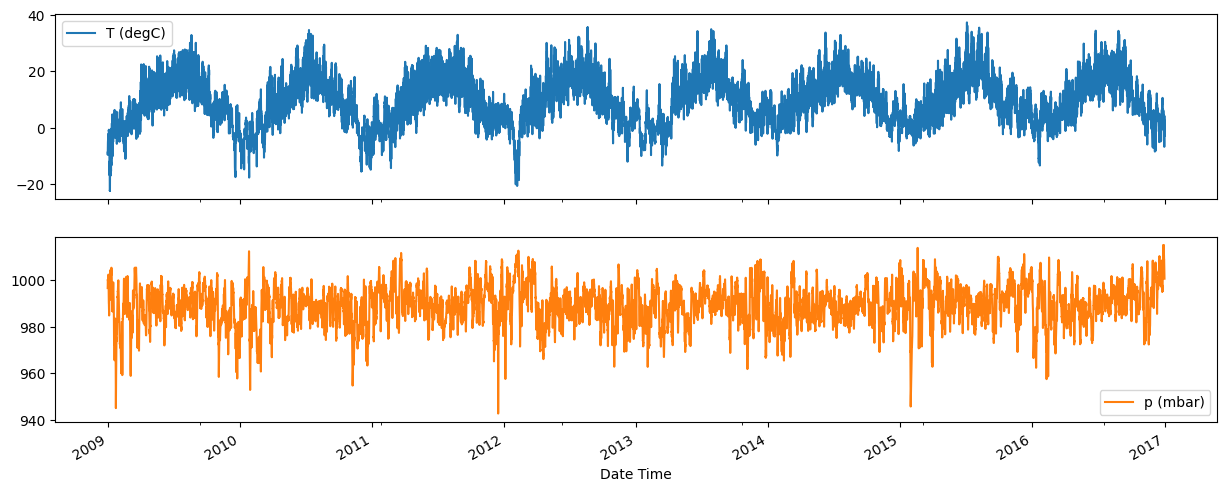

In [13]:
# lets plot the data
plot_cols = ['T (degC)', 'p (mbar)']
plot_features = df_12[plot_cols]
plot_features.index = date_time
# plot the data
plot_features.plot(subplots=True, figsize=(15, 6))

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>],
      dtype=object)

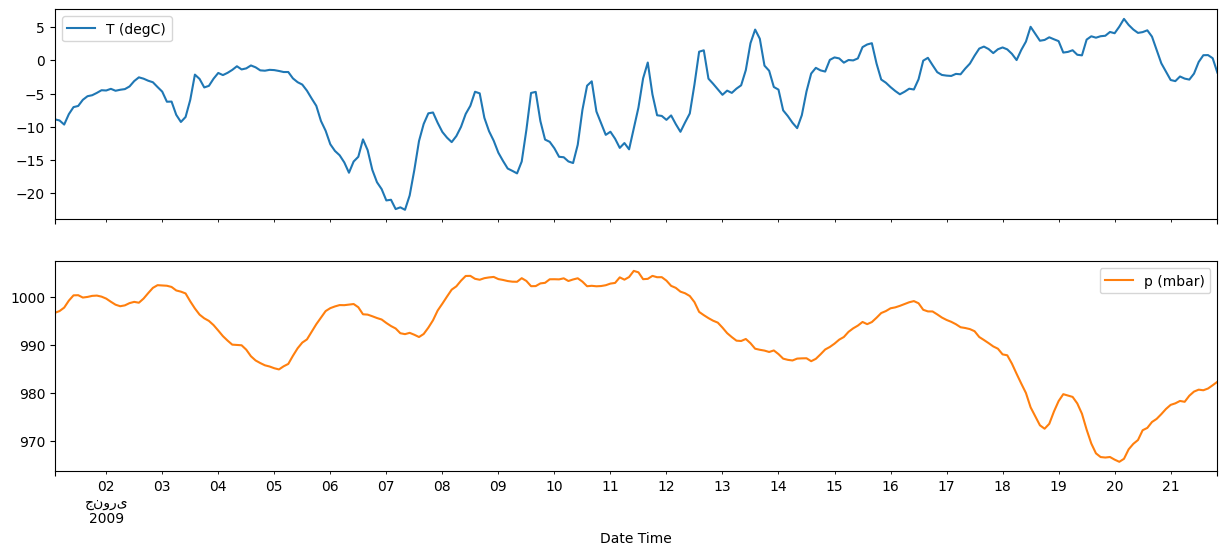

In [14]:
# lets plot only first 500 hours, which is equal to 250 rows because each row is 2 hours
# lets plot the data
plot_cols = ['T (degC)', 'p (mbar)']
plot_features = df_12[plot_cols][:250]
plot_features.index = date_time[:250]
# plot the data
plot_features.plot(subplots=True, figsize=(15, 6))

In [15]:
# lets make same plot using plotly
fig = px.line(plot_features, x=plot_features.index, y=plot_cols[0], title='Weather Data Over Time')
fig.show()

fig = px.line(plot_features, x=plot_features.index, y=plot_cols[1], title='Weather Data Over Time')
fig.update_traces(line_color='orange') # change color to orange
fig.show()

In [16]:
# lets make same plot using plotly
fig = px.line(df_12, x=date_time, y=plot_cols[0], title='Weather Data Over Time')
fig.show()

fig = px.line(df_12, x=date_time, y=plot_cols[1], title='Weather Data Over Time')
fig.update_traces(line_color='orange') # change color to orange
fig.show()

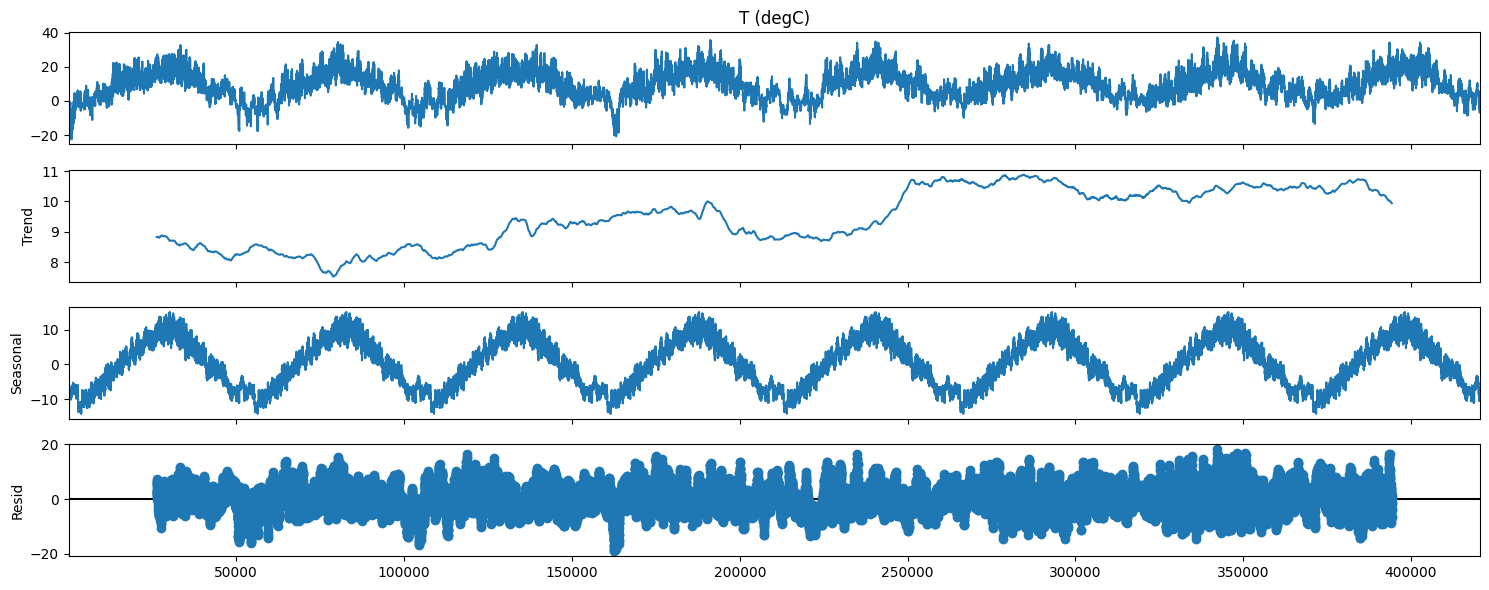

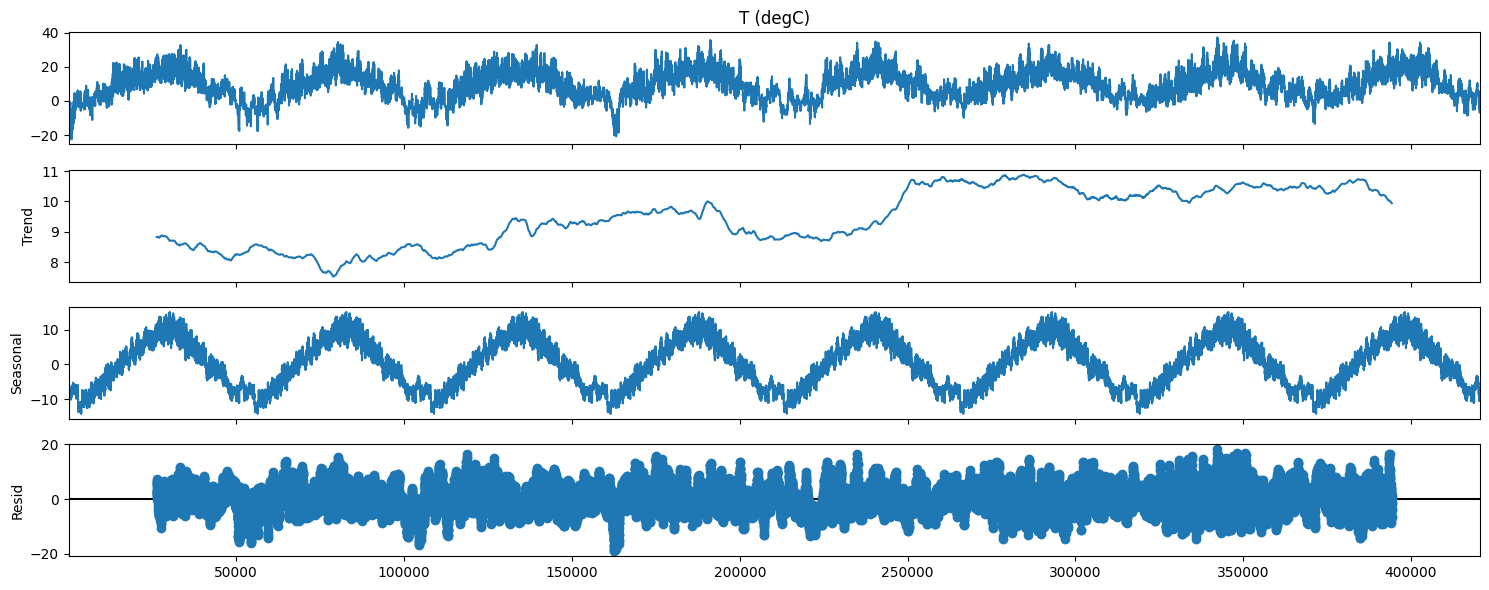

In [ ]:
# lets decompose the data - checking temperature
result = seasonal_decompose(df_12['T (degC)'], model='additive', period=12*365) # period for 1 year = (no.of hours in a day) * (no. of days in a year) = 12 * 365 means seasonality is based on 365 days (1 year)
result.plot()

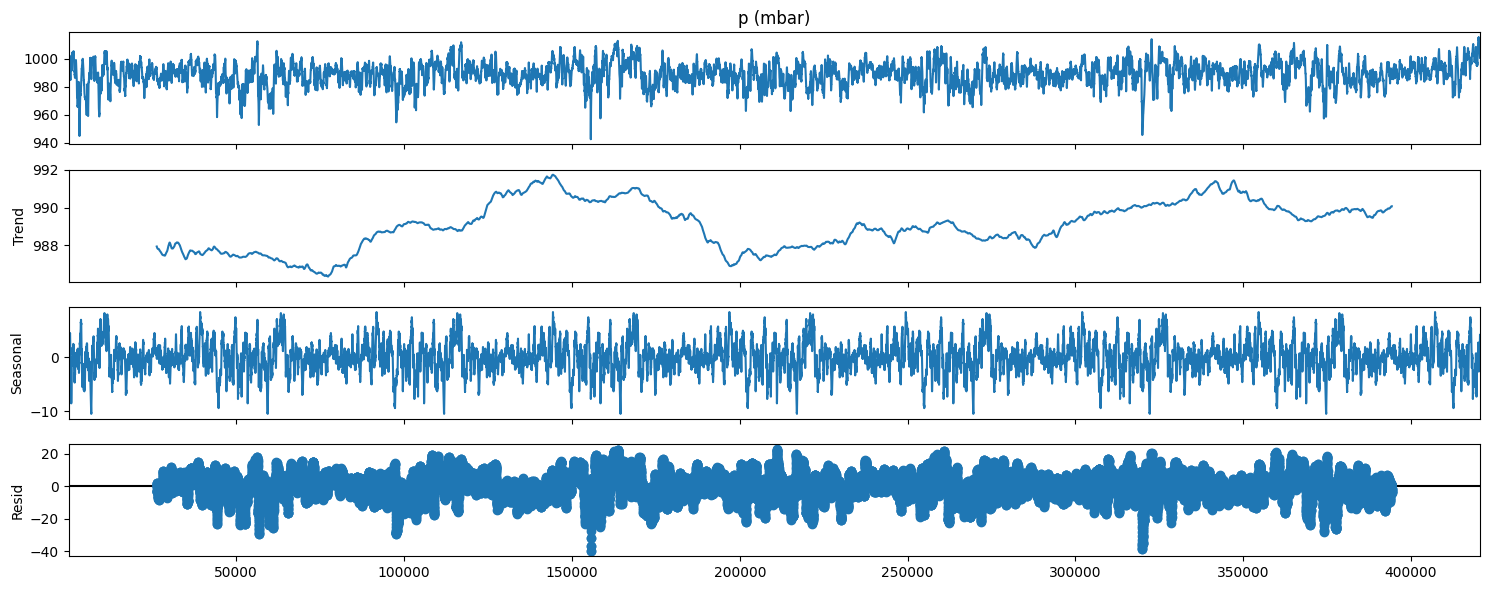

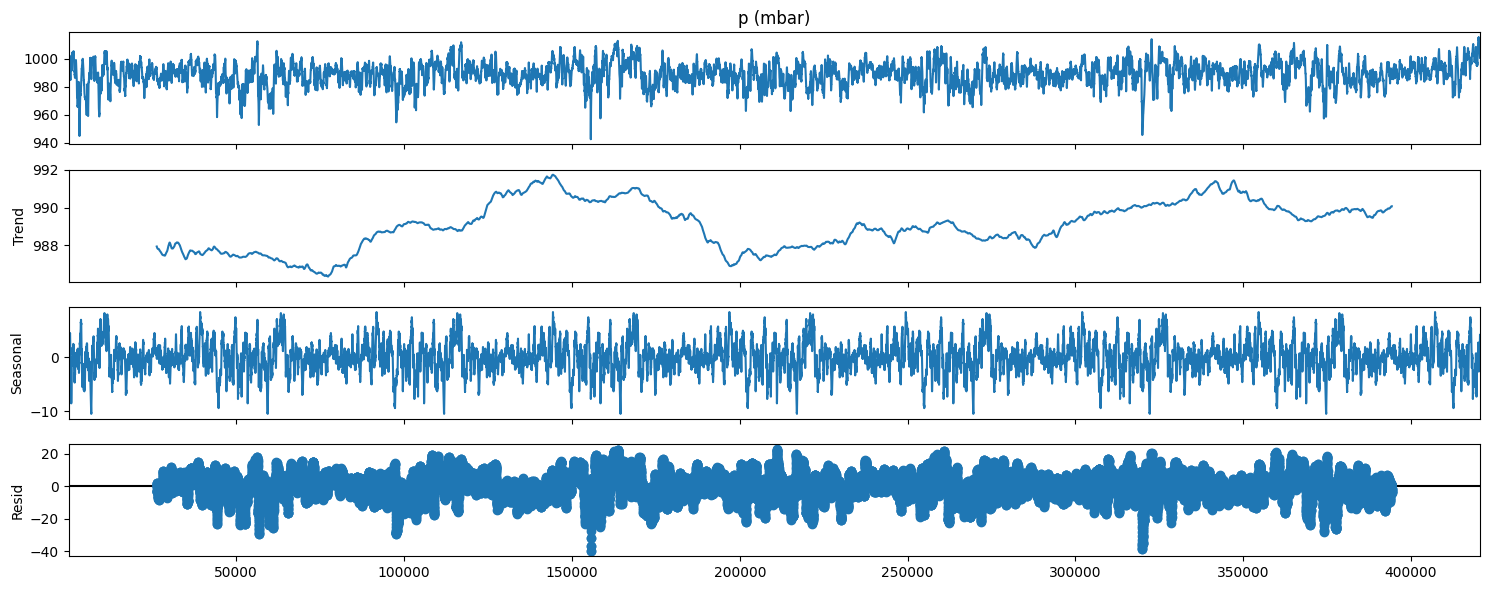

In [19]:
# lets decompose the data - checking pressure
result = seasonal_decompose(df_12['p (mbar)'], model='additive', period=12*365)
result.plot()

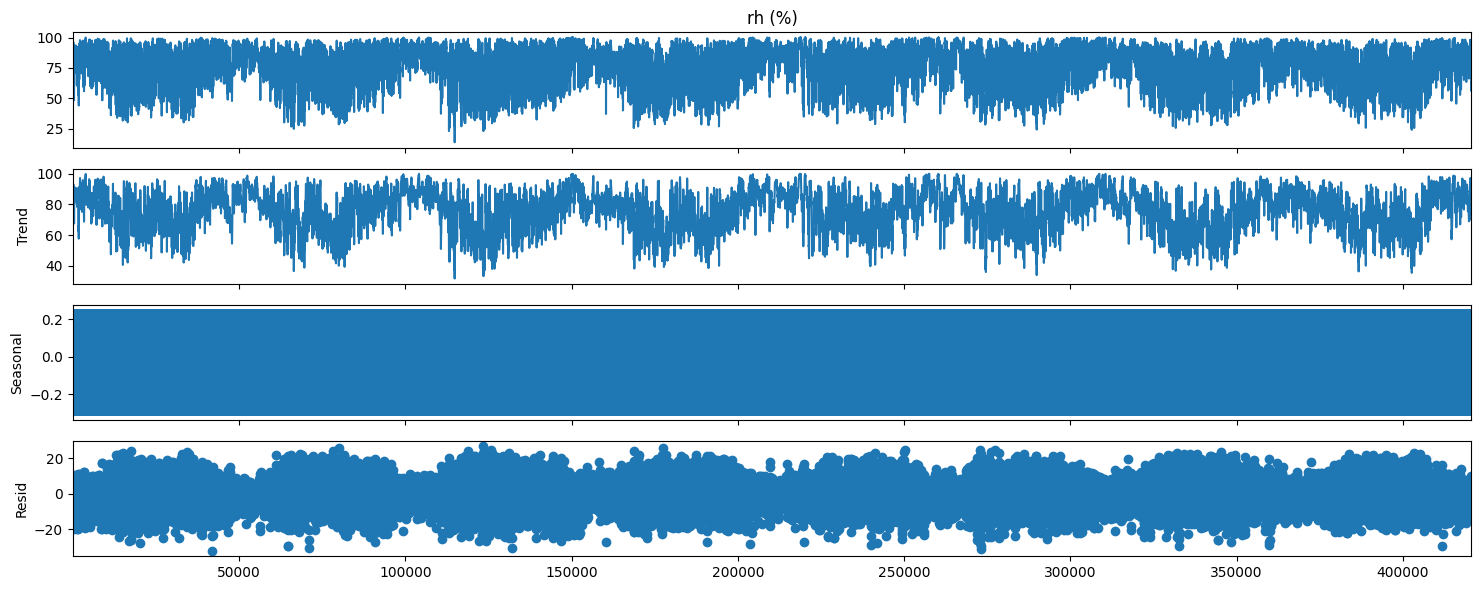

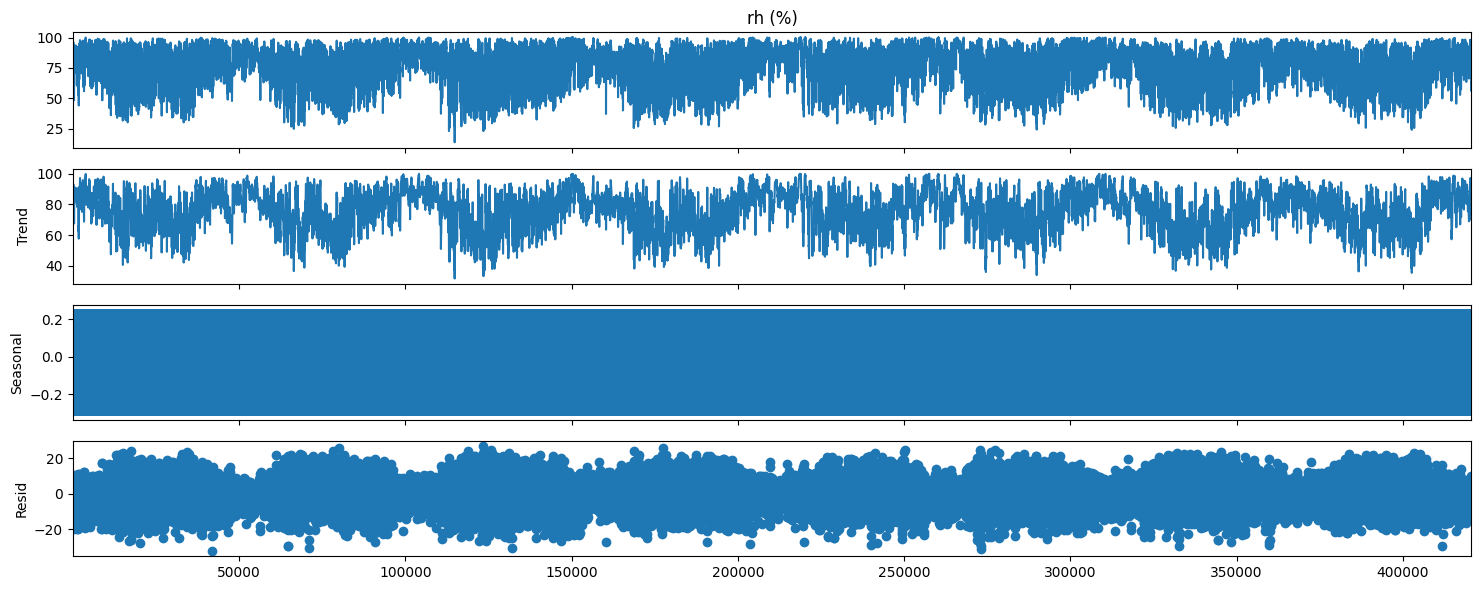

In [20]:
# lets decompose the data - checking relative humidity
result = seasonal_decompose(df_12['rh (%)'], model='additive', period=8) # period=1 means no seasonality i.e; take each value
result.plot()

In [21]:
# clean up the data
df_12.isnull().sum() # check for null values

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [22]:
# print all columns and rows of describe for df_12, without breaking columns into next line
pd.set_option('display.width', 1000) # set display width
print(df_12.describe().transpose())


                   count         mean        std      min      25%      50%      75%      max
p (mbar)         35045.0   989.213079   8.353850   942.65   984.20   989.57   994.72  1015.16
T (degC)         35045.0     9.450335   8.425301   -22.50     3.36     9.43    15.49    37.28
Tpot (K)         35045.0   283.492908   8.506133   251.22   277.44   283.48   289.55   311.21
Tdew (degC)      35045.0     4.955012   6.729168   -24.55     0.24     5.22    10.08    22.19
rh (%)           35045.0    76.006020  16.483440    13.88    65.15    79.30    89.50   100.00
VPmax (mbar)     35045.0    13.577314   7.743076     0.99     7.77    11.83    17.62    63.77
VPact (mbar)     35045.0     9.532714   4.181965     0.83     6.22     8.86    12.36    26.79
VPdef (mbar)     35045.0     4.044542   4.902793     0.00     0.87     2.18     5.30    46.01
sh (g/kg)        35045.0     6.021744   2.654692     0.52     3.92     5.60     7.81    17.13
H2OC (mmol/mol)  35045.0     9.639148   4.233082     0.83   

In [23]:
# replace negative values with 0 for wv(wind velosity) and max wind velosity
wv = df_12['wv (m/s)']
wv[wv < 0] = 0 # replace negative values with 0
wv

11        0.25
23        0.10
35        0.05
47        0.72
59        1.45
          ... 
420491    0.58
420503    0.46
420515    0.44
420527    1.02
420539    0.35
Name: wv (m/s), Length: 35045, dtype: float64

In [24]:
# replace negative values with 0 for max wv(wind velosity)
wv_max = df_12['max. wv (m/s)']
wv_max[wv_max < 0] = 0 # replace negative values with 0
wv_max

11        0.63
23        0.38
35        0.50
47        1.25
59        3.00
          ... 
420491    1.32
420503    1.08
420515    1.00
420527    1.92
420539    0.68
Name: max. wv (m/s), Length: 35045, dtype: float64

# Modeling

In [25]:
df_12.shape

(35045, 14)

In [26]:
# split the data into train, validation and test --> 70-20-10
train_size = int(len(df_12) * 0.7) # 70% of the data for training
val_size = int(len(df_12) * 0.2) # 20% of the data for validation
test_size = len(df_12) - train_size - val_size # 10% of the data for testing

train_df = df_12[:train_size]
val_df = df_12[train_size:train_size + val_size]
test_df = df_12[train_size + val_size:]

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)


Train shape: (24531, 14)
Validation shape: (7009, 14)
Test shape: (3505, 14)


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

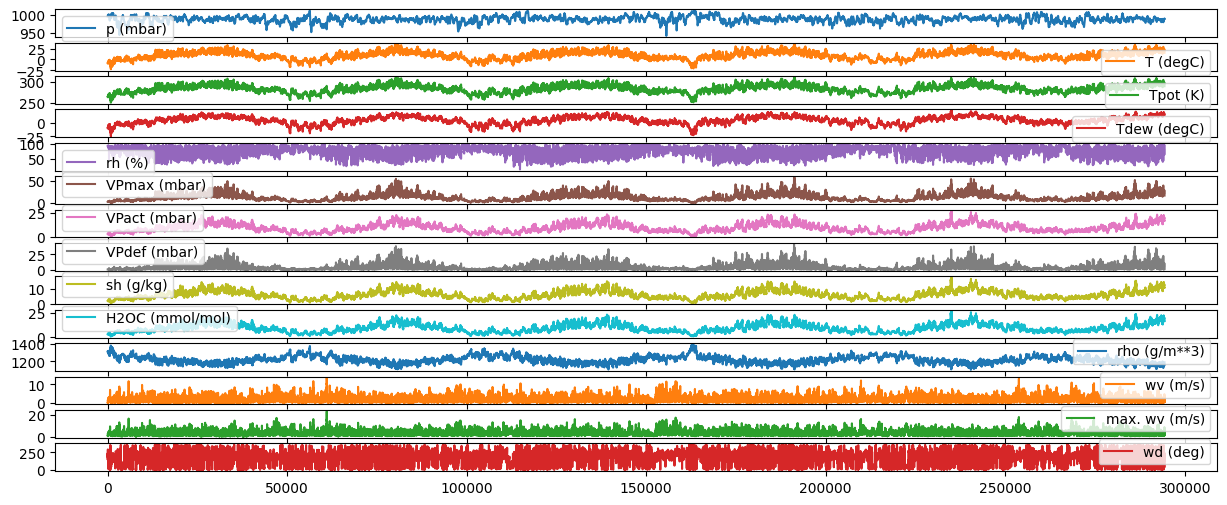

In [27]:
# lets plot data of train_df with all columns
train_df.plot(subplots=True, figsize=(15, 6))

In [28]:
# lets normalize the data
# we will use the mean and standard deviation of the training data to normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

# lets normalize the training data
train_df = (train_df - train_mean) / train_std # z-score normalization
# lets normalize the validation data
val_df = (val_df - train_mean) / train_std # z-score normalization
# lets normalize the test data
test_df = (test_df - train_mean) / train_std # z-score normalization

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >], dtype=object)

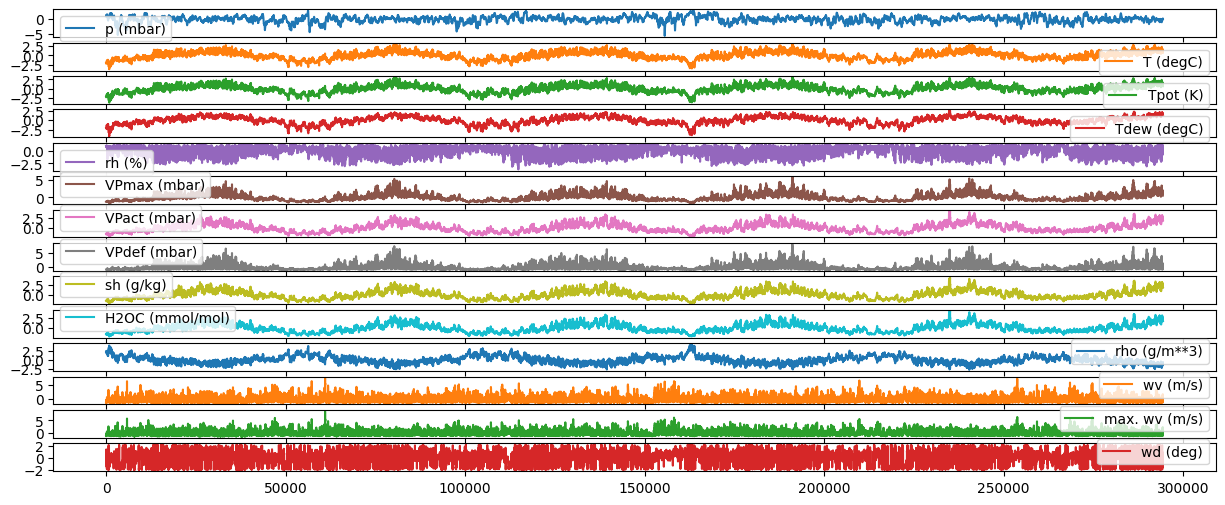

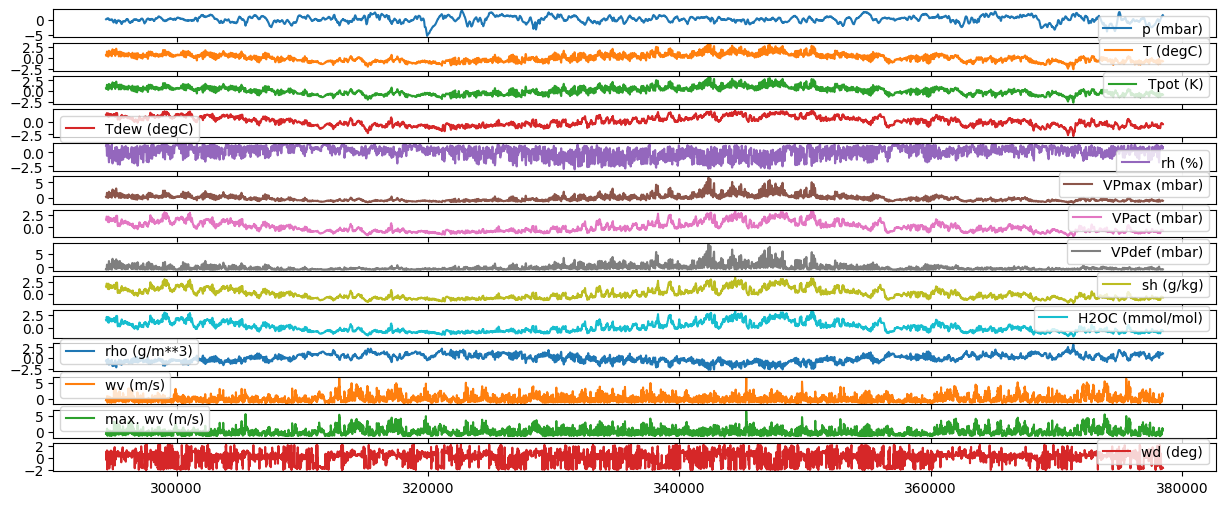

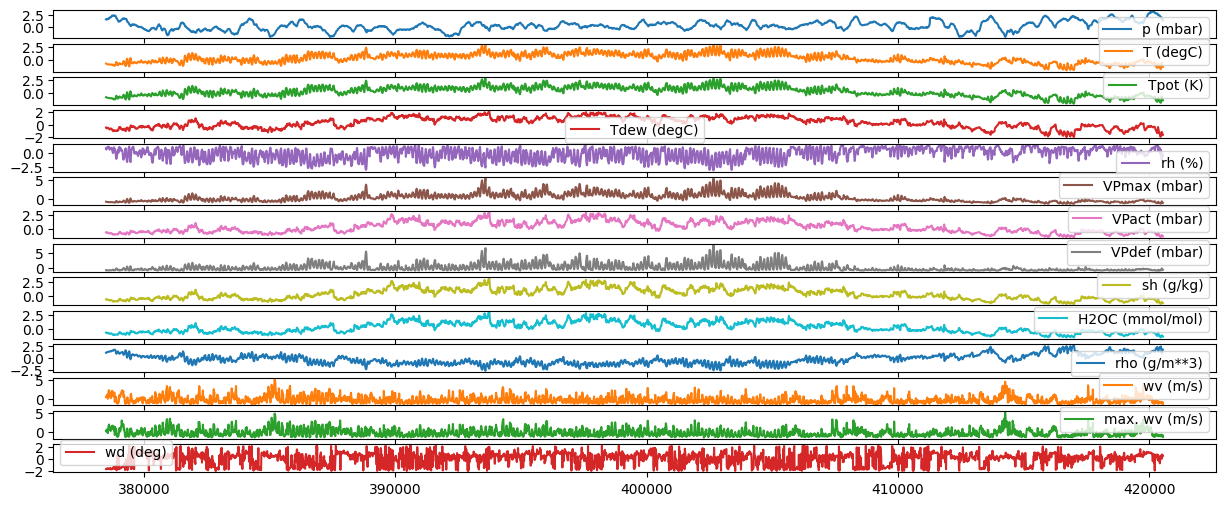

In [30]:
# lets plot the data
train_df.plot(subplots=True)

# lets plot the data
val_df.plot(subplots=True)

# lets plot the data
test_df.plot(subplots=True)


In [ ]:
# lets make the model to predict the temperature
# lets make the windowed dataset
# we will use the windowed dataset to train the model
# we will use the windowed dataset to validate the model
# we will use the windowed dataset to test the model
# we will use the windowed dataset to predict the model
# we will use the windowed dataset to plot the model

# lets make the windowed datas